## import required packages

In [1]:
#a super learner model for regression
from math import sqrt
from numpy import vstack
from numpy import asarray
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor

Using TensorFlow backend.


In [2]:
import numpy as np
import pandas as pd
from numpy import hstack
from numpy import array
import pygeostat as gs
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import subprocess as sp
%pylab inline --no-import-all
from subprocess import check_output
import tensorflow as tf
from tensorflow.python import debug as tf_debug
import os
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

Populating the interactive namespace from numpy and matplotlib


C:\Users\gamze\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Create Trend

## 01. Variogram model

In [3]:
griddef = gs.GridDef(gridfl='griddef.txt')
griddef

varg = ("1    0.01                   -nst, nugget effect\n\
         3    0.99   0   0.0   0.0   -it,cc,azm,dip,tilt (ang1,ang2,ang3)\n\
         200  150    150             -a_hmax, a_hmin, a_vert (ranges)")

## 02. Simulation

In [4]:
sgsimpar = '''                  Parameters for SGSIM
                  ********************

START OF PARAMETERS:
cluster.dat           -file with data
1  2  3  4  0  0              -  columns for X,Y,Z,vr,wt,sec.var.
-1.0       1.0e21             -  trimming limits
0                             -  transform the data (0=no, 1=yes)
sgsim.trn                     -  file for output trans table
0                             -  consider ref. dist (0=no, 1=yes)
histsmth.out                  -  file with ref. dist distribution
1  2                          -  columns for vr and wt
0.0    15.0                   -  zmin,zmax(tail extrapolation)
1       0.0                   -  lower tail option, parameter
1      15.0                   -  upper tail option, parameter
1                             -  debugging level: 0,1,2,3
sgsim.dbg                     -  file for debugging output
sgsim.out                     -  file for simulation output
1                             -  number of realizations to generate
{grid}
69069                         -  random number seed
0     8                       -  min and max original data for sim
48                            -  number of simulated nodes to use
1                             -  assign data to nodes (0=no, 1=yes)
1     3                       -  multiple grid search (0=no, 1=yes),num
0                             -  maximum data per octant (0=not used)
250  250.0  150.0             -  maximum search radii (hmax,hmin,vert)
 0.0   0.0   0.0              -  angles for search ellipsoid
51    51    11                -  size of covariance lookup table
0     0.60   1.0              -  ktype: 0=SK,1=OK,2=LVM,3=EXDR,4=COLC
../data/ydata.dat             -  file with LVM, EXDR, or COLC variable
4                             -  column for secondary variable
{varg}

'''
sgsim= gs.Program(program='sgsim',parfile='sgsim.par')


sgsim.run(parstr=sgsimpar.format(varg = varg, grid = griddef))

Calling:  ['sgsim', 'sgsim.par']

 SGSIM Version: 4.000

  data file = cluster.dat                             
  input columns =            1           2           3           4           0
           0
  trimming limits =   -1.000000      1.0000000E+21
  transformation flag =            0
  transformation file = sgsim.trn                               
  consider smoothed distribution (1=yes) =            0
  file with smoothed distribution = histsmth.out                            
  columns =            1           2
  data limits (tails) =   0.0000000E+00   15.00000    
  lower tail =            1  0.0000000E+00
  upper tail =            1   15.00000    
  debugging level =            1
  debugging file = sgsim.dbg                               
  output file sgsim.out                               
  number of realizations =            1
  X grid specification =           50   5.000000       10.00000    
  Y grid specification =           50   5.000000       10.00000    
  Z grid

## 03. lognormal and addcord

In [5]:
logn = gs.Program('logn')

lognpar = """              Convert to logn
             *********************************

START OF PARAMETERS:
{datafl}                           - data file
1   0.5                            - mean and standard deviation you want
logn.out                           - output file with lognormal data
"""
sgsimfl = gs.DataFile('sgsim.out')

logn.run(parstr=lognpar.format(datafl = sgsimfl))

Calling:  ['logn', 'temp']

 LOGNORM Version:          1.1000

  data file = sgsim.out                               
  mean and stdev you want =    1.00000000000000       0.500000000000000     
  file for output = logn.out                                

Finished converting    62500 values
 ERROR in parameter file


In [6]:
addcoordpar = '''                  Parameters for ADDCOORD
                  ***********************

START OF PARAMETERS:
{datafl}                         - file with data
addcoord.out                     - file for output
1                                - realization number
{grid}
3 3 6                            - decimals for x, y, z (-1=exclude)
'''

addcoord= gs.Program(program='addcoord',parfile='addcoord.par')

logn = gs.DataFile('logn.out',griddef=griddef)
addcoord.run(parstr=addcoordpar.format(datafl=logn.flname,grid = griddef))

Calling:  ['addcoord', 'addcoord.par']

 ADDCOORD VERSION: 4.1.0

 Data File = logn.out                                
 Output File = addcoord.out                            
 Realization number =            1
 X grid size =           50   5.00000000000000        10.0000000000000     
 Y grid size =           50   5.00000000000000        10.0000000000000     
 Z grid size =           25   5.00000000000000        10.0000000000000     
 decimals =            3           3           6
 
 Format: (f07.03,x,f07.03,x,f10.06,x,a)      

 ADDCOORD: 4.1.0 Finished



## 04. make a trend

In [7]:
maketrend = gs.Program('maketrend', getpar = True)

C:\Users\gamze\Desktop\SCI Paper 1-son - Major\Codes\Non-Gaussian synthetic dataset\tmps8_wi495/maketrend.par has been copied to the clipboard


In [8]:
maketrendpar = """              Parameters for MAKETREND
              ************************

START OF PARAMETERS:
{datafl}               - file with data
{xyzcol}               - columns for X, Y, Z coordinates
1  {varcol}            - number of variables,column numbers
-99     99             - trimming limits
2                      - trend type: 0 - vertical; 1 - aerial; 2 - 3D
1 50.0 1000            - calibrate 3D trend with vertical trend, 1=yes, and radius, num neighbors
0                      - type of averaging volume: 0 - sphere, 1 - cube
150.0 2000 25.0        - search radii
0.0 0.0                - azimuth and dip
50                     - nearest neighbors to use (0 for all)
1000                   - distance cutoff
0                      - weighting function: 0 - equal, 1 - Gaussian
0 3                    - apply post processing filter: 1 - yes, number of iterations
51 51 5                - filter size: nx, ny, nz
0                      - filter weighting function: 0 - equal, 1 - Gaussian
1                      - ensure sum to 1 for compositional trends: 1 - yes
maketrend.out          - file for trend output
{griddef}
1                      - output count and radius info, 1=yes


Additional Options/Notes
 - for vertical trends, a 2D/3D model is output if nx and/or ny are > 1
 - for aerial trends, a 3D model is output if nz > 1
 - ensuring a sum to 1 is only applied for multiple variables
"""

lognfl = gs.DataFile('addcoord.out')
maketrend.run(parstr=maketrendpar.format(datafl=lognfl.flname,griddef = griddef,varcol=lognfl.gscol('value'),
                                        xyzcol= lognfl.gscol(lognfl.xyz)))

Calling:  ['maketrend', 'temp']

 MAKETRENDS Version: 1.000

 data file = addcoord.out
 columns for x,y,z =    1   2   3
 number of variables =   1
 variable columns =    4
 trimmming limits =  -99.00   99.00
 trend type = 3D
 3D trend calibration option, radius, NN =  1  50.00 1000
 volume type =  0
 search radii =  150.00 2000.00   25.00
 azimuth and dip =    0.00    0.00
 nearest neighbors =     50
 distance cutoff =    1000.00
 weighting function = equal
 filter option and iterations =  0  3
 filter size in x,y,z blocks =   51  51   5
 filter weighting function = equal
 ensure sum constraint =   1
 output file = maketrend.out
 grid spec in x =   50        5.00   10.00
 grid spec in y =   50        5.00   10.00
 grid spec in z =   25        5.00   10.00
 count and radius output option =   1
   Reading in the data
 Found    0 duplicates in the data
 computing vertical trend

    working on slice       2
    working on slice       4
    working on slice       6
    working on slice   

In [9]:
from scipy.stats import kurtosis, skew
sgsimfl = gs.DataFile('maketrend.out',griddef=griddef)
skew(sgsimfl.data['variable 1'])


0.8811639121469582

In [11]:
# If skewness is less than -1 or greater than 1, the distribution is highly skewed.
# If skewness is between -1 and -0.5 or between 0.5 and 1, the distribution is moderately skewed.
# If skewness is between -0.5 and 0.5, the distribution is approximately symmetric.

## 05. sampling

In [12]:
gsample= gs.Program(program='gsample',parfile='gsample.par')


In [13]:
gsamplepar = '''       Parameters for gsample V2.000
     *********************************
       
START OF PARAMETERS:
1                            - Number of files to sample
{datafl}                     - File with first grid
1  {varcol1}                 - Number of variables and columns
1                            - Realization to sample
{griddef}
0                            - Sampling spacing option (0=regular, 1=random)
125  125                     - If 0, spacing in X, Y
65  65                       - If 0, collar of the first sample, X and Y (inside sampling grid)
100  69069                   - If 1, number of drill holes and seed number
0  90                        - Azimuth and dip
10                           - Sample spacing downhole
1                            - Starting drill hole ID for new drills
2                            - Number of decimal places (coordinates precision, up to 6)
5   495                      - Sampling grid: xmin, xmax
5   495                      -                ymin, ymax
5   245                      -                zmin, zmax
dhs.out                      - Output file with new drill holes
0                            - Output keyout file? (0=no, 1=yes)
0                            - If keyout (0=input grid inside sampling grid, 1=input blocks with assays)
keyout.out         - Keyout file
------------------------------------------------
 -- OPTIONAL Extra Options for random drill sampling (sampling option 1) 
      NOTE: if extra option is used sampling will only occure in middle of blocks 
0                            - Use Extra Options (0 = NO, 1 = YES)
15  15                       - Minimum spacing in x and y direction - Note: dont use 0
------------------------------------------------
NOTE: using the minimum drill spacing could cause some issues
      with not drilling the number of drill holes that you
      really want to drill. So keep the minimum spacing low
Useing the extra option will force drilling to center of block
   and will only allow 1 drillhole per block - even if the
   minimum spacing is a lot smaller than a block size
'''

sgsimfl = gs.DataFile('maketrend.out',griddef=griddef)

gsample.run(parstr=gsamplepar.format(datafl=sgsimfl.flname,
                                           varcol1=sgsimfl.gscol('variable 1'),
                                           griddef=griddef
                                           ))

Calling:  ['gsample', 'gsample.par']

GSAMPLE Version: 2.000

PARAMETER FILE                  = gsample.par                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
-----------------------------------------------------------------------------

INPUT PARAMETERS 

Number of grids to sample       =   1
Total number of variables       =   1
 
Data file  1                    = 
maketrend.out
Variable columns                =   1
 
Sample realization number       =   1
 
Input grid 
Input grid in X                 =   50        5.00   10.00
Input grid in Y

## 06. trend variogram

In [14]:
varsim = gs.Program('varsim')
varsimparstr = """                 Parameters for VarSim
                 *********************

START OF PARAMETERS:
../data/lithology.dat            - file with lithology information
0   7                            - lithology column (0=not used), code
{datafl}                         - file with data
1   1                            - number of variables, column numbers
-1.0e21     1.0e21               - trimming limits
./variograms/varsim_reals.out    - output file for variograms of realizations
./variograms/varsim_avg.out      - output file for average variogram
{griddef}
1                                - number of realizations
3  50                            - number of directions, number of lags
1  0  0                          - ixd(1),iyd(1),izd(1)
0  1  0                          - ixd(2),iyd(2),izd(2)
0  0  1                          - ixd(2),iyd(2),izd(2)
1                                - standardize sill? (0=no, 1=yes)
1                                - number of variograms
1   1   1                        - tail variable, head variable, variogram type
"""
varsim.run(varsimparstr.format(datafl = sgsimfl,
                               griddef = griddef),quiet=True,liveoutput=False)
vargplt =  gs.DataFile('./variograms/varsim_reals.out')

In [15]:
sgsimfl = gs.DataFile('maketrend.out',griddef=griddef)

datasample = gs.DataFile(flname='dhs.out', x='X',y='Y',z='Z', griddef = griddef,readfl=True)


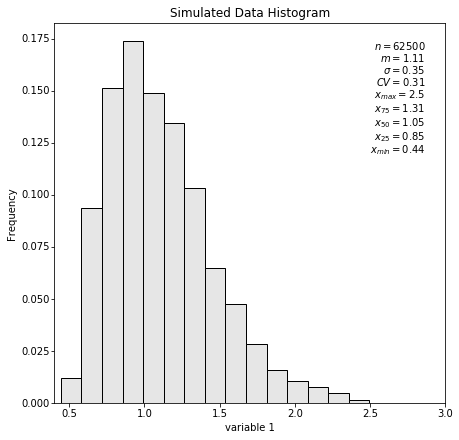

In [16]:
gs.histplt(sgsimfl.data,var ='variable 1', xlim = (0.4,3), title = ('Simulated Data Histogram'),figsize =(7,7))

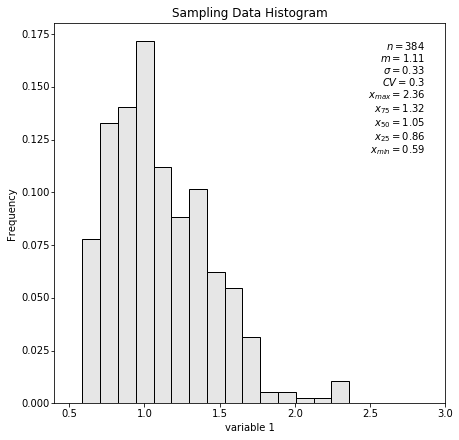

In [17]:
gs.histplt(datasample.data,var ='variable 1', xlim = (0.4,3), title = ('Sampling Data Histogram'),figsize =(7,7))

In [18]:
datasample.data.describe()

,Drill ID,X,Y,Z,MD,Block ID,variable 1
count,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000
mean,8.500000,252.500000,252.500000,130.000000,115.000000,32526.000000,1.108629
std,4.615786,139.936576,139.936576,69.312175,69.312175,17342.400103,0.327916
min,1.000000,65.000000,65.000000,15.000000,0.000000,2807.000000,0.587200
25%,4.750000,158.750000,158.750000,72.500000,57.500000,17666.500000,0.857525
50%,8.500000,252.500000,252.500000,130.000000,115.000000,32526.000000,1.048900
75%,12.250000,346.250000,346.250000,187.500000,172.500000,47385.500000,1.323475
max,16.000000,440.000000,440.000000,245.000000,230.000000,62245.000000,2.361900


### location maps

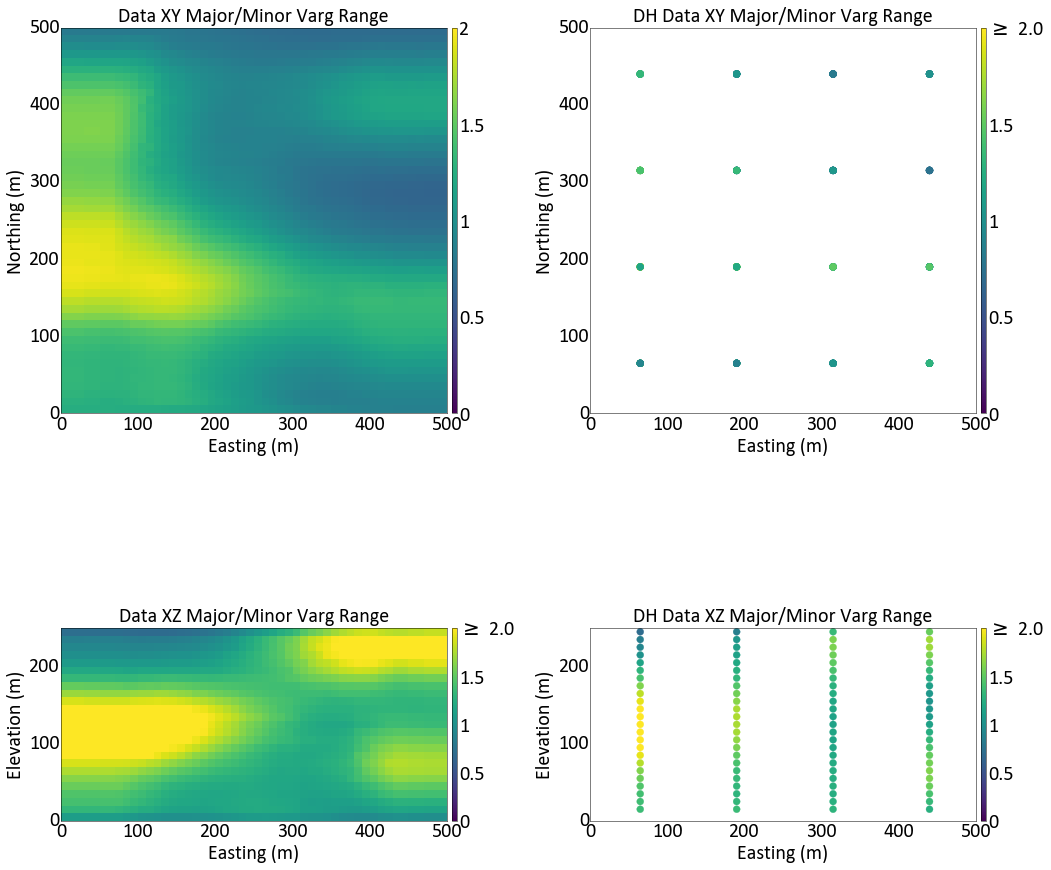

In [19]:
vlim = (0,2.0)
gs.set_style('pt20')
xlim = (0, 360)

f, axes = plt.subplots(2, 2, figsize=(15, 15)) 

    
gs.pixelplt(sgsimfl,var='variable 1',sliceno= 15, ax = axes[0,0],title = ('Data XY Major/Minor Varg Range'),vlim=vlim)
gs.pixelplt(sgsimfl,var='variable 1',orient='xz',sliceno=15, ax = axes[1,0],title = ('Data XZ Major/Minor Varg Range'),vlim=vlim)

gs.locmap(datasample,var = 'variable 1',orient='xy', ax = axes[0,1],sliceno= 15,title = ('DH Data XY Major/Minor Varg Range'),vlim=vlim)
gs.locmap(datasample,var = 'variable 1',orient='xz', ax = axes[1,1],sliceno= 15,title = ('DH Data XZ Major/Minor Varg Range'),vlim=vlim)

plt.tight_layout()


plt.savefig('./Figures/Data_Sample_Hist.png',bbox_inches = 'tight', dpi = 150)

In [20]:
# 3D output
outvtkfl = 'trend_out.vtk'
datasample.writefile(flname=outvtkfl, fltype='VTK')

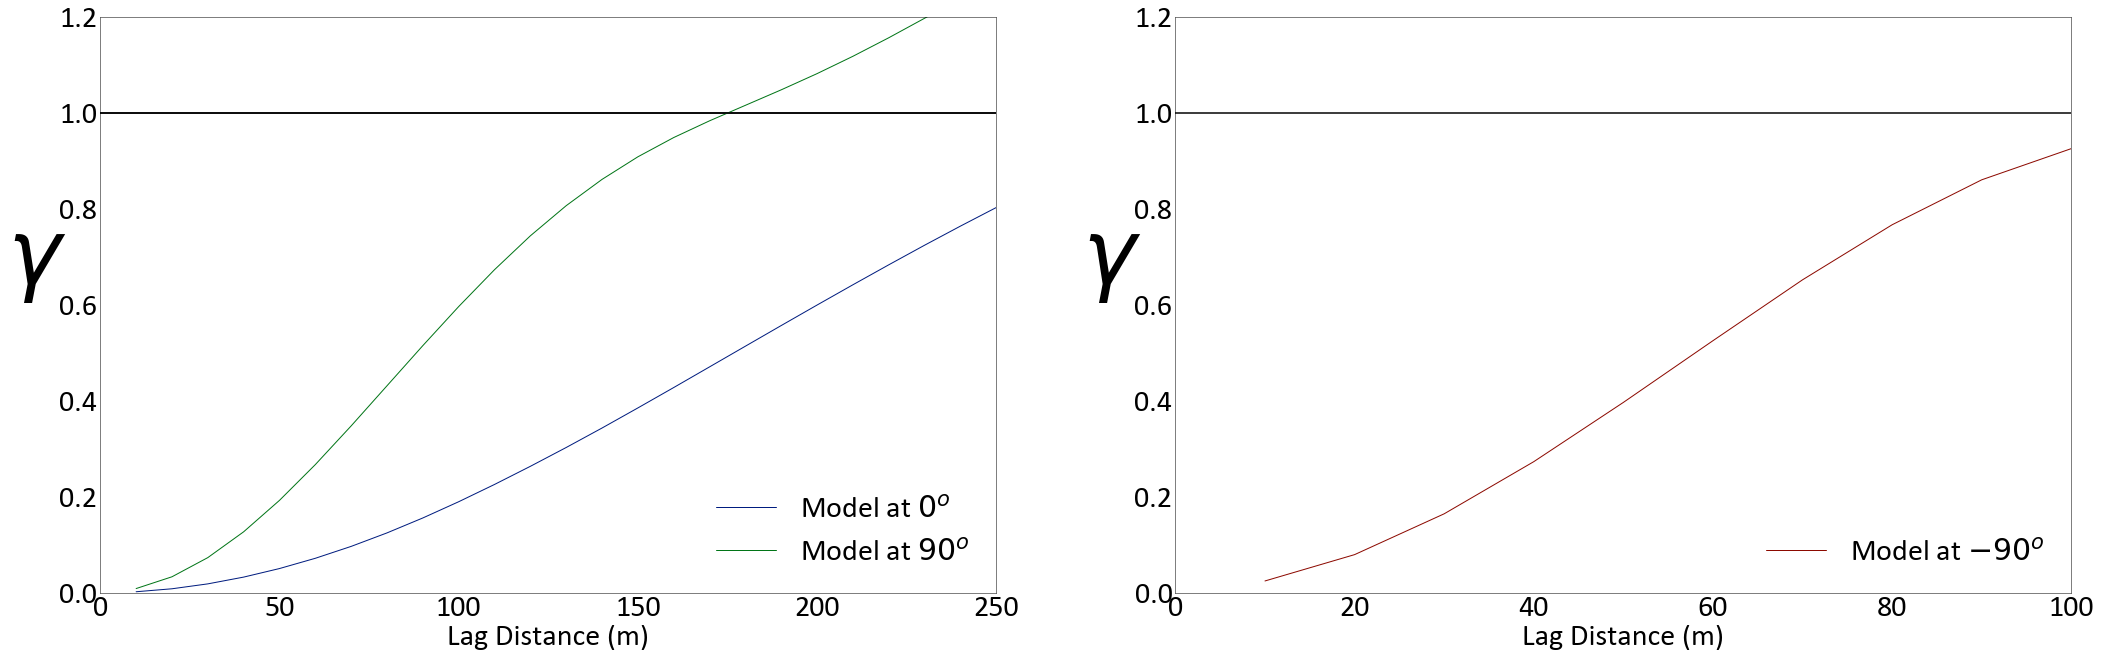

<Figure size 216x216 with 0 Axes>

In [21]:
varsim = gs.Program('varsim')
varsimparstr = """                 Parameters for VarSim
                 *********************

START OF PARAMETERS:
../data/lithology.dat        -file with lithology information
0   7                        -lithology column (0=not used), code
{datafl}                     -file with data
1   1                        -number of variables, column numbers
-1.0e21     1.0e21           -trimming limits
./varsim_reals.out     -output file for variograms of realizations
./varsim_avg.out       -output file for average variogram
{griddef}
1                            -number of realizations
3  50                        -number of directions, number of lags
1  0  0                      -ixd(1),iyd(1),izd(1)
0  1  0                      -ixd(2),iyd(2),izd(2)
0  0  1                      -ixd(2),iyd(2),izd(2)
1                            -standardize sill? (0=no, 1=yes)
1                            -number of variograms
1   1   1                    -tail variable, head variable, variogram type
"""

gs.set_style('pt30')
xlim = (0,250)

f, (ax,ax2) = plt.subplots(1, 2, figsize=(15,10))
colors = gs.get_palette('cat_dark', 3, cmap=False)

dataflpoints = gs.DataFile(flname='dhs.out', x='X',y='Y',z='Z', griddef = griddef,readfl=True)

sgsimfl = gs.DataFile('maketrend.out',griddef=griddef)
    
varsim.run(varsimparstr.format(datafl = sgsimfl, griddef = griddef),quiet=True,liveoutput=False)

vargplt_data =  gs.DataFile('./varsim_reals.out')
    
gs.varplt(vargplt_data,index = 1,experimental=False,color=colors[0] ,label = 'Model at $0^{o}$', ax = ax, xlim =xlim)
gs.varplt(vargplt_data,index = 2,experimental=False,color=colors[1] ,label = 'Model at $90^{o}$', ax = ax, xlim =xlim)
gs.varplt(vargplt_data,index = 3,experimental=False,color=colors[2] ,label = 'Model at $-90^{o}$', ax = ax2, xlim =(0,100))

ax.legend (loc = 4, fontsize=30)
ax2.legend (loc = 4, fontsize=30)

plt.tight_layout()    
plt.subplots_adjust (left = 0.125, bottom = 0.1, right = 1.95, top = 0.9, wspace = 0.2, hspace = 0.55)
plt.savefig('./Figures/sim_sample_variogram.png', bbox_inches = 'tight', dpi = 150)
plt.show()

plt.tight_layout()



# MACHINE LEARNING 

# SUPER LEARNER

### Data Preperation

In [22]:
datafl = gs.DataFile('maketrend.out',griddef=griddef)
datasamplefl = gs.DataFile('dhs.out',griddef=griddef)
datasamplefl = pd.DataFrame(datasamplefl.data, dtype = np.float32)
del datasamplefl['Drill ID']
del datasamplefl['MD']
del datasamplefl['Block ID']
datasamplefl['Z'] = datasamplefl['Z']

In [23]:
datasamplefl.describe()

,X,Y,Z,variable 1
count,384.000000,384.000000,384.00000,384.000000
mean,252.500000,252.500000,130.00000,1.108629
std,139.936584,139.936584,69.31218,0.327916
min,65.000000,65.000000,15.00000,0.587200
25%,158.750000,158.750000,72.50000,0.857525
50%,252.500000,252.500000,130.00000,1.048900
75%,346.250000,346.250000,187.50000,1.323475
max,440.000000,440.000000,245.00000,2.361900


In [24]:
#DH Sample Data
datatest = np.asarray(datasamplefl)
min_val = np.min(datatest[:,3])
max_val = np.max(datatest[:,3])

print(min_val)
print(max_val)

y = (datatest[:,3]-min_val)/(max_val-min_val)
X = datatest[:,0:3]/100

print(X.shape, y.shape)


0.5872
2.3619
(384, 3) (384,)


In [25]:
#Prediction Grid
x,Y,Z = griddef.gridcoord()
X_all = np.hstack((x.reshape(len(x),1),Y.reshape(len(Y),1),Z.reshape(len(Z),1)))/100
y_all = datafl.data['variable 1']

print('input', X_all.shape, y_all.shape)


input (62500, 3) (62500,)


### Hyperparameter Tuning with Grid Search

In [26]:
# # # Hyperparameter Tuning with Grid Search- All models except NN
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import RepeatedKFold
# scoring = 'neg_mean_squared_error'
# seed = 7
# models_to_run = [SVR(kernel='rbf', gamma= 'scale'), 
#                  GradientBoostingRegressor(random_state=seed), 
#                  KNeighborsRegressor(), 
#                  RandomForestRegressor(random_state=seed), 
#                  BaggingRegressor(random_state=seed),
#                  ExtraTreesRegressor(random_state=seed),
#                  DecisionTreeRegressor(random_state=seed),
#                  AdaBoostRegressor(random_state=seed)]

# models_param_grid = [{ # 1st param grid, corresponding to SVR
#                         'C': [10, 100,1000],
#                         'epsilon': [0.01, 0.1, 1] 
#                     }, 
#                     { # 2nd param grid, corresponding to GBM
#                         'n_estimators': [800,900,1000],
#                         'learning_rate':[0.01, 0.1, 0.15, 0.2],
#                         'max_depth' : [4,5,6]
#                     },
#                     { # 3rd param grid, corresponding to KNN
#                             'n_neighbors': [2,3,4]
#                     },
#                     { # 4rd param grid, corresponding to RF
#                             'n_estimators': [1000,1200,1400]
#                     },
#                     { # 5rd param grid, corresponding to BAG
#                             'n_estimators' : [1000,1200,1400]
#                     },
#                     { # 7th param grid, corresponding to ET
#                             'n_estimators' : [1000,1200,1400]
#                     },
#                     { # 8th param grid, corresponding to DT
#                             'max_depth' : [10,14,16]
#                     },
#                     { # 9th param grid, corresponding to ADA
#                             'n_estimators' : [100,200,300]
#                     }
#                     ]                            

# # define split of data
# kfold = RepeatedKFold(n_splits=5, n_repeats=5, random_state=seed)
# # Tuning
# for i,model in enumerate(models_to_run):
#     grid = GridSearchCV(model, param_grid=models_param_grid[i], scoring=scoring, cv=kfold)
#     grid_result = grid.fit(X, y)
#     print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [27]:
# #Tune the Number of Neurons in one Hidden Layer

# def wider_model(neurons=1):
# 	# create model
# 	model = Sequential()
# 	model.add(Dense(neurons, input_dim=3, kernel_initializer='normal', activation='relu'))
# 	model.add(Dense(1, kernel_initializer='normal'))
# 	# Compile model
# 	model.compile(loss='mean_squared_error', optimizer='adam')
# 	return model

# # fix random seed for reproducibility
# seed = 7
# numpy.random.seed(seed)
# model6 = KerasRegressor(build_fn=wider_model, verbose=0, epochs=500,batch_size=40)

# # define the grid search parameters
# neurons = [5,10,15,20]
# param_grid = dict(neurons=neurons)
# grid = GridSearchCV(estimator=model6, param_grid=param_grid, n_jobs=-1, cv=kfold)
# grid_result = grid.fit(X, y)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

In [28]:
# #Tune the Number of  Hidden Layers

# def wider_model(optimizer='adam', activation = 'sigmoid', hidden_layers=1):
# 	# create model
# 	model = Sequential()
# 	model.add(Dense(20, input_dim=3, kernel_initializer='normal', activation='relu'))
    
# 	for i in range(hidden_layers):
# 		# Add one hidden layer
# 		model.add(Dense(20, activation=activation))

# 	model.add(Dense(1, kernel_initializer='normal'))
# 	# Compile model
# 	model.compile(loss='mean_squared_error', optimizer='adam')
# 	return model

# # fix random seed for reproducibility
# seed = 7
# numpy.random.seed(seed)
# model6 = KerasRegressor(build_fn=wider_model, verbose=0, epochs=500,batch_size=40)
# hidden_layers =[2,3,4,5]

# param_grid = dict(hidden_layers=hidden_layers)
# grid = GridSearchCV(estimator=model6, param_grid=param_grid, n_jobs=-1, cv=kfold)
# grid_result = grid.fit(X, y)

# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

In [29]:
# #Tune Batch Size and Number of Epochs

# # define the model
# def wider_model():
# 	# create model
# 	model = Sequential()
# 	model.add(Dense(20, input_dim=3, kernel_initializer='normal', activation='relu'))
# 	model.add(Dense(20, kernel_initializer='normal', activation='relu'))
# 	model.add(Dense(20, kernel_initializer='normal', activation='relu'))
# 	model.add(Dense(1, kernel_initializer='normal'))
# 	# Compile model
# 	model.compile(loss='mean_squared_error', optimizer='adam')
# 	return model

# # fix random seed for reproducibility
# seed = 7
# numpy.random.seed(seed)
# model6 = KerasRegressor(build_fn=wider_model, verbose=0)

# # define the grid search parameters
# batch_size = [10,20, 40, 60, 80, 100]
# epochs = [100,200,300,400,500]
# param_grid = dict(batch_size=batch_size, epochs=epochs)
# grid = GridSearchCV(estimator=model6, param_grid=param_grid, n_jobs=-1, cv=kfold)
# grid_result = grid.fit(X, y)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

### Super Learner 

In [30]:
# define base model
def baseline_model():
	# create model
	model = Sequential()
	model.add(Dense(20, input_dim=3, kernel_initializer='normal', activation='relu'))
	model.add(Dense(20, kernel_initializer='normal', activation='relu'))
	model.add(Dense(20, kernel_initializer='normal', activation='relu'))
	model.add(Dense(1, kernel_initializer='normal'))
	# Compile model
	model.compile(loss='mean_squared_error', optimizer='adam')
	return model

In [31]:
# create a list of base-models
def get_models():
	models = list()
	models.append(SVR(C= 1000,epsilon = 0.01, kernel='rbf', gamma='scale'))
	models.append(GradientBoostingRegressor(n_estimators = 1000, learning_rate = 0.2, max_depth= 4))
	models.append(KNeighborsRegressor(n_neighbors=2))
	models.append(RandomForestRegressor(n_estimators=1200))
	models.append(BaggingRegressor(n_estimators=1200))
	models.append(KerasRegressor(build_fn=baseline_model, batch_size = 10, epochs=500, verbose=0))
	models.append(ExtraTreesRegressor(n_estimators=1400,n_jobs = 3))
	models.append(DecisionTreeRegressor(max_depth= 14))
	models.append(AdaBoostRegressor(n_estimators=100))
	return models

In [32]:
# collect out of fold predictions form k-fold cross validation
seed=7

def get_out_of_fold_predictions(X, y, models):
	meta_X, meta_y = list(), list()
	# define split of data
	kfold = KFold(n_splits=5, shuffle=True,random_state=seed)
	# enumerate splits
	fold_num= 0
	columns = ['X','Y','Z','value']
	for train_ix, test_ix in kfold.split(X):
		fold_num += 1
		fold_yhats = list()
		# get data
		train_X, test_X = X[train_ix], X[test_ix]
		train_y, test_y = y[train_ix], y[test_ix]
		meta_y.extend(test_y)
		# fit and make predictions with each sub-model
		for model in models:
			model.fit(train_X, train_y)
			yhat = model.predict(test_X)
			# store columns
			fold_yhats.append(yhat.reshape(len(yhat),1))
		# store fold yhats as columns
		meta_X.append(hstack(fold_yhats))      
	return vstack(meta_X), asarray(meta_y)

In [33]:
# fit all base models on the training dataset
def fit_base_models(X, y, models):
	for model in models:
		model.fit(X, y)
 

In [34]:
# fit a meta model
def fit_meta_model(X, y):
	model = LinearRegression()
	model.fit(X, y)
	return model

In [35]:
# evaluate a list of models on a dataset
def evaluate_models(X, y, models):
	for model in models:
		yhat = model.predict(X)
		mse = mean_squared_error(y, yhat)
		print('%s: RMSE %.3f' % (model.__class__.__name__, sqrt(mse)))

In [36]:
def evaluate_r2_models(X, y, models):
	for model in models:
		yhat = model.predict(X)
		r2 = r2_score(y, yhat)
		print('%s: R2 %.3f' % (model.__class__.__name__, r2))

In [37]:
# make predictions with stacked model
def super_learner_predictions(X, models, meta_model):
	meta_X = list()
	for model in models:
		yhat = model.predict(X)
		meta_X.append(yhat.reshape(len(yhat),1))
	meta_X = hstack(meta_X)
	# predict
	return meta_model.predict(meta_X)

In [38]:
# get models
models = get_models()

In [39]:
# get out of fold predictions
meta_X, meta_y = get_out_of_fold_predictions(X, y, models)
print('Meta ', meta_X.shape, meta_y.shape)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Meta  (384, 9) (384,)


In [40]:
# fit base models
fit_base_models(X, y, models)

In [41]:
from sklearn.linear_model import LinearRegression
# fit the meta model
meta_model = fit_meta_model(meta_X, meta_y)


In [42]:
# evaluate a list of models on a dataset
def evaluate_models_all(X, y, models):
	for model in models:
		yhat = model.predict(X)*(max_val-min_val)+min_val
		mse = mean_squared_error(y, yhat)
		print('%s: RMSE %.3f' % (model.__class__.__name__, sqrt(mse)))

In [43]:
evaluate_models_all(X_all, y_all, models)

SVR: RMSE 0.143
GradientBoostingRegressor: RMSE 0.171
KNeighborsRegressor: RMSE 0.174
RandomForestRegressor: RMSE 0.170
BaggingRegressor: RMSE 0.170
KerasRegressor: RMSE 0.200
ExtraTreesRegressor: RMSE 0.135
DecisionTreeRegressor: RMSE 0.171
AdaBoostRegressor: RMSE 0.235


In [44]:
def evaluate_r2_models_all(X, y, models):
	for model in models:
		yhat = model.predict(X)*(max_val-min_val)+min_val
		r2 = r2_score(y, yhat)
		print('%s: R2 %.3f' % (model.__class__.__name__, r2))

In [45]:
evaluate_r2_models_all(X_all, y_all, models)

SVR: R2 0.829
GradientBoostingRegressor: R2 0.756
KNeighborsRegressor: R2 0.748
RandomForestRegressor: R2 0.758
BaggingRegressor: R2 0.758
KerasRegressor: R2 0.666
ExtraTreesRegressor: R2 0.848
DecisionTreeRegressor: R2 0.756
AdaBoostRegressor: R2 0.538


In [46]:
# evaluate meta model on X_all
yhat_all = super_learner_predictions(X_all, models, meta_model)*(max_val-min_val)+min_val
print('Stacking Learner: RMSE %.3f' % (sqrt(mean_squared_error(y_all, yhat_all))))
print('Stacking Learner: R2 %.3f' % (r2_score(y_all, yhat_all)))

Stacking Learner: RMSE 0.128
Stacking Learner: R2 0.864


### Averaging base models

In [47]:
def predict_models(X, models):
	ests = list()
	for model in models:
		est = model.predict(X)
		ests.append(est.reshape(len(est),1))
	return hstack(ests)

In [48]:
ests = predict_models(X_all, models)*(max_val-min_val)+min_val
ests.shape

(62500, 9)

In [49]:
average=numpy.nanmean(ests, axis =1)
average

array([1.36699961, 1.35931308, 1.35119981, ..., 1.19485475, 1.19774232,
       1.19983267])

In [50]:
print('Averaging: RMSE %.3f' % (sqrt(mean_squared_error(y_all, average))))
print('Averaging: R2 %.3f' % (r2_score(y_all, average)))

Averaging: RMSE 0.149
Averaging: R2 0.814


# KRIGING

In [51]:
declusstr = """                  Parameters for DECLUS
                  *********************

START OF PARAMETERS:
{datafl}         -file with data
{xyzcol}   {varcol}               - columns for X, Y, Z, and variable
-1.0e21     1.0e21                - trimming limits
declus.sum                        - file for summary output
declus.out                        - file for output with data & weights
1.0   1.0                         - Y and Z cell anisotropy (Ysize=size*Yanis)
0                                 - 0=look for minimum declustered mean (1=max)
50  25  200.0                     - number of cell sizes, min size, max size
100                               - number of origin offsets
"""
varcparstr = """                  Parameters for VARCALC
                  **********************
 
START OF PARAMETERS:
{datafl}                         - file with data
{xyzcol}                         - columns for X, Y, Z coordinates
1   {varcol}                     - number of variables,column numbers (position used for tail,head variables below)
-99.0    1.0e21                  - trimming limits
3                                - number of directions
0 15 200 0.0 22.5 200 0.0        - Dir 01: azm,azmtol,bandhorz,dip,dipt
 20  125  70                     - number of lags,lag distanc
90  15 200 0.0 22.5 200 0.0      - Dir 01: azm,azmtol,bandhorz,dip,dipt
 20  125  70                     - number of lags,lag distanc
0. 22.5 200 90.0 22.5 200 0.0    - Dir 03: azm,azmtol,bandhorz,dip,
 20  10  5                       - number of lags,lag distanc
./variograms/varcalc.out         - file for experimental variogram points output.
0                                - legacy output (0=no, 1=write out gamv2004 format)
1                                - run checks for common errors
1                                - standardize sills? (0=no, 1=yes)
1                                - number of variogram types
1   1   1   ?                    - tail variable, head variable, variogram type (and cutoff/category), sill

"""
varmparstr = """                  Parameters for VARMODEL
                  ***********************
 
START OF PARAMETERS:
./variograms/varmodel.out     - file for modeled variogram points output
3                             - number of directions to model points along
    0.0  00.0  1000   0.5     - azm, dip, npoints, point separation
    90.0  00.0  1000   0.5    - azm, dip, npoints, point separation
    0.0  90.0  1000   0.5     - azm, dip, npoints, point separation
1    0.001:0.01               - nst, nugget effect
3    0.99    0   0.0   0.0    - it,cc,azm,dip,tilt (ang1,ang2,ang3)
        75:1000  100  75:300  - a_hmax, a_hmin, a_vert (ranges)
1   2000000                   - fit model (0=no, 1=yes), maximum iterations
1.0                           - variogram sill (can be fit, but not recommended in most cases)
1                             - number of experimental files to use
{varcalc}                     - experimental output file 1
3   1  2  3                   - # of variograms (<=0 for all), variogram #s
1   1   10                    - # pairs weighting, inverse distance weighting, min pairs
0     10.0                    - fix Hmax/Vert anis. (0=no, 1=yes)
0      1.0                    - fix Hmin/Hmax anis. (0=no, 1=yes)
./variograms/varmodel.var              -  file to save fit variogram model
"""
kt3dnparstr = """                 Parameters for KT3DN
                 ********************
START OF PARAMETERS:
{datafl}             -file with data
0  {xyzcol} {varcol}  0          - columns for DH,X,Y,Z,var,sec var
-998.0    1.0e21                 - trimming limits
0                                - option: 0=grid, 1=cross, 2=jackknife
xvk.dat                          - file with jackknife data
1   2   0    3    0              - columns for X,Y,Z,vr and sec var
kt3dn_dataspacing.out            - data spacing analysis output file (see note)
0    15.0                        - number to search (0 for no dataspacing analysis, rec. 10 or 20) and composite length
0    100   0                     - debugging level: 0,3,5,10; max data for GSKV;output total weight of each data?(0=no,1=yes)
kt3dn.dbg-nkt3dn.sum             - file for debugging output (see note)
./predictions/kt3dn.out          - file for kriged output (see GSB note)
{griddef}
1    1      1                    - x,y and z block discretization
25    50    12    1              - min, max data for kriging,upper max for ASO,ASO incr
90      0                        - max per octant, max per drillhole (0-> not used)
500.0  500.0  250.0              - maximum search radii
90.0  0.0   0.0                  - angles for search ellipsoid
0                                - 0=SK,1=OK,2=LVM(resid),3=LVM((1-w)*m(u))),4=colo,5=exdrift,6=ICCK
{mean} 0.6  0.8                  - mean (if 0,4,5,6), corr. (if 4 or 6), var. reduction factor (if 4)
0 0 0 0 0 0 0 0 0                - drift: x,y,z,xx,yy,zz,xy,xz,zy
0                                - 0, variable; 1, estimate trend
extdrift.out                     - gridded file with drift/mean
4                                - column number in gridded file
keyout.out                       - gridded file with keyout (see note)
0    1                           - column (0 if no keyout) and value to keep
{varg}
"""

In [52]:
varcalc = gs.Program('varcalc')
varmodel = gs.Program('varmodel')
kt3dn = gs.Program('kt3dn')
declus = gs.Program('declus') 

Traindat = gs.DataFile('dhs.out',griddef=griddef)

declus.run(declusstr.format(datafl = Traindat.flname,
                         xyzcol = Traindat.gscol(Traindat.xyz),
                         varcol = Traindat.gscol('variable 1')))
    
declus_mean = np.min(np.asarray(gs.DataFile('declus.sum').data['Declustered Mean']
                                [gs.DataFile('declus.sum').data['Cell Size']>0.0]))

    
    
varcalc.run(varcparstr.format(datafl = Traindat.flname,
                             xyzcol = Traindat.gscol(Traindat.xyz),
                             varcol = Traindat.gscol('variable 1')))

varcalcfl = gs.DataFile('./variograms/varcalc.out')

   
varmodel.run(varmparstr.format(varcalc = varcalcfl.flname))

varmodelfl = gs.DataFile('./variograms/varmodel.out')

f = open("./variograms/varmodel.var", "r")
varg = f.readlines()
f.close()
varg = ''.join(varg)
    
kt3dn.run(kt3dnparstr.format(datafl = Traindat.flname,
                             xyzcol = Traindat.gscol(Traindat.xyz),
                             varcol = Traindat.gscol('variable 1'),
                             griddef = griddef,
                             varg = varg,
                             mean = declus_mean))

Calling:  ['declus', 'temp']

 DECLUS Version: 3.001

  data file = dhs.out                                 
  columns =            2           3           4           7
  tmin,tmax =  -1.0000000E+21  1.0000000E+21
  summary file = declus.sum                              
  output file = declus.out                              
  anisotropy =    1.000000       1.000000    
  minmax flag =            0
  ncell min max =           50   25.00000       200.0000    
  offsets =          100
 

 There are      384 data with:
   mean value            =      1.10863
   minimum and maximum   =      0.58720     2.36190
   size of data vol in X =    375.00000
   size of data vol in Y =    375.00000
   size of data vol in Z =    230.00000

   declustered mean      =      1.08718
   min and max weight    =      0.49900     2.81441
   equal weighting       =      1.00000


 DECLUS Version: 3.001 Finished

Calling:  ['varcalc', 'temp']

varcalc version:  1.400

  data file: dhs.out
  x,y,z columns:  

# The combination of kriging and SL (SK+SL)

## Weights

In [53]:
columns =['Estimate']
pltdat_kt3dn = gs.DataFile('./predictions/kt3dn.out',griddef=griddef)
SK = array(pltdat_kt3dn.data['Estimate']).reshape((len(pltdat_kt3dn.data['Estimate']), 1))
gs.write_gslib(pd.DataFrame(SK, columns=columns ),'./predictions/SK.dat')
SK.shape

(62500, 1)

In [54]:
SK_variance = array(pltdat_kt3dn.data['EstimationVariance']).reshape((len(pltdat_kt3dn.data['EstimationVariance']), 1))
gs.write_gslib(pd.DataFrame(SK_variance, columns =['EstimationVariance']),'./predictions/SK_var.dat')

In [55]:
min_val = np.min(SK_variance)
max_val = np.max(SK_variance)
print(min_val)
print(max_val)
SK_st_variance= (SK_variance-min_val)/(max_val-min_val)
gs.write_gslib(pd.DataFrame(SK_st_variance),'./predictions/SK_st_var.dat')

0.0
0.95088731


In [56]:
W  = hstack(SK_st_variance+ 0.0000000000000001)

In [57]:
SK = hstack(SK)
print('SK: RMSE %.3f' % (sqrt(mean_squared_error(y_all, SK))))
print('SK: R2 %.3f' % (r2_score(y_all, SK)))

SK: RMSE 0.166
SK: R2 0.769


## Optimization

In [58]:
from scipy.optimize import minimize

In [59]:
def objective(weights):
    b0, b1 = weights[0], weights[1]
    for weight in zip(weights):
        final_prediction = W ** ((b0 + b1 * SK)) * yhat_all + (1-W+0.0000000000000001) ** ((b0 + b1 * SK)) * SK
    return sqrt(mean_squared_error(y_all, final_prediction))

In [60]:
objective([0, 0])

1.129184624405091

In [61]:
starting_values = [0, 0]

#our weights are bound between 0 and 1
bounds = [(0,3),(-2,3)]

res = minimize(objective, starting_values, method='SLSQP', bounds=bounds,options={'disp': True, 'ftol':1e-20})

print('Ensemble Score: {best_score}'.format(best_score=res['fun']))
print('Best Weights: {weights}'.format(weights=res['x']))

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.1235427020843081
            Iterations: 14
            Function evaluations: 57
            Gradient evaluations: 14
Ensemble Score: 0.1235427020843081
Best Weights: [ 1.26762956 -0.23305332]


In [62]:
superlearner_opt  = hstack(W**(res['x'][0]+res['x'][1] * SK) * yhat_all + (1-W)**(res['x'][0]+res['x'][1]* SK) * SK)
superlearner_opt 

y_last = hstack(y_all)
y_last.shape

print('superlearner_opt: RMSE %.3f' % (sqrt(mean_squared_error(y_last, superlearner_opt))))
print('superlearner_opt: R2 %.3f' % (r2_score(y_last, superlearner_opt)))

superlearner_opt: RMSE 0.124
superlearner_opt: R2 0.873


## Non-optimized

In [63]:
#Testing b0 = 1 b1 =0

superlearner_comb= hstack(W * yhat_all + (1-W)* SK)
superlearner_comb

print('SL, b=1, RMSE: %.3f' % (sqrt(mean_squared_error(y_last, superlearner_comb))))
print('SL, b=1, R2: %.3f' % (r2_score(y_last, superlearner_comb)))

SL, b=1, RMSE: 0.131
SL, b=1, R2: 0.857


## Map of weights

In [64]:
WeightofML = W**(res['x'][0]+res['x'][1]* SK)
WeightofSK = (1-W)**(res['x'][0]+res['x'][1]* SK)

In [65]:
gs.write_gslib(pd.DataFrame(WeightofSK),'./predictions/WeightofSK.dat')
gs.write_gslib(pd.DataFrame(WeightofML),'./predictions/WeightofML.dat')

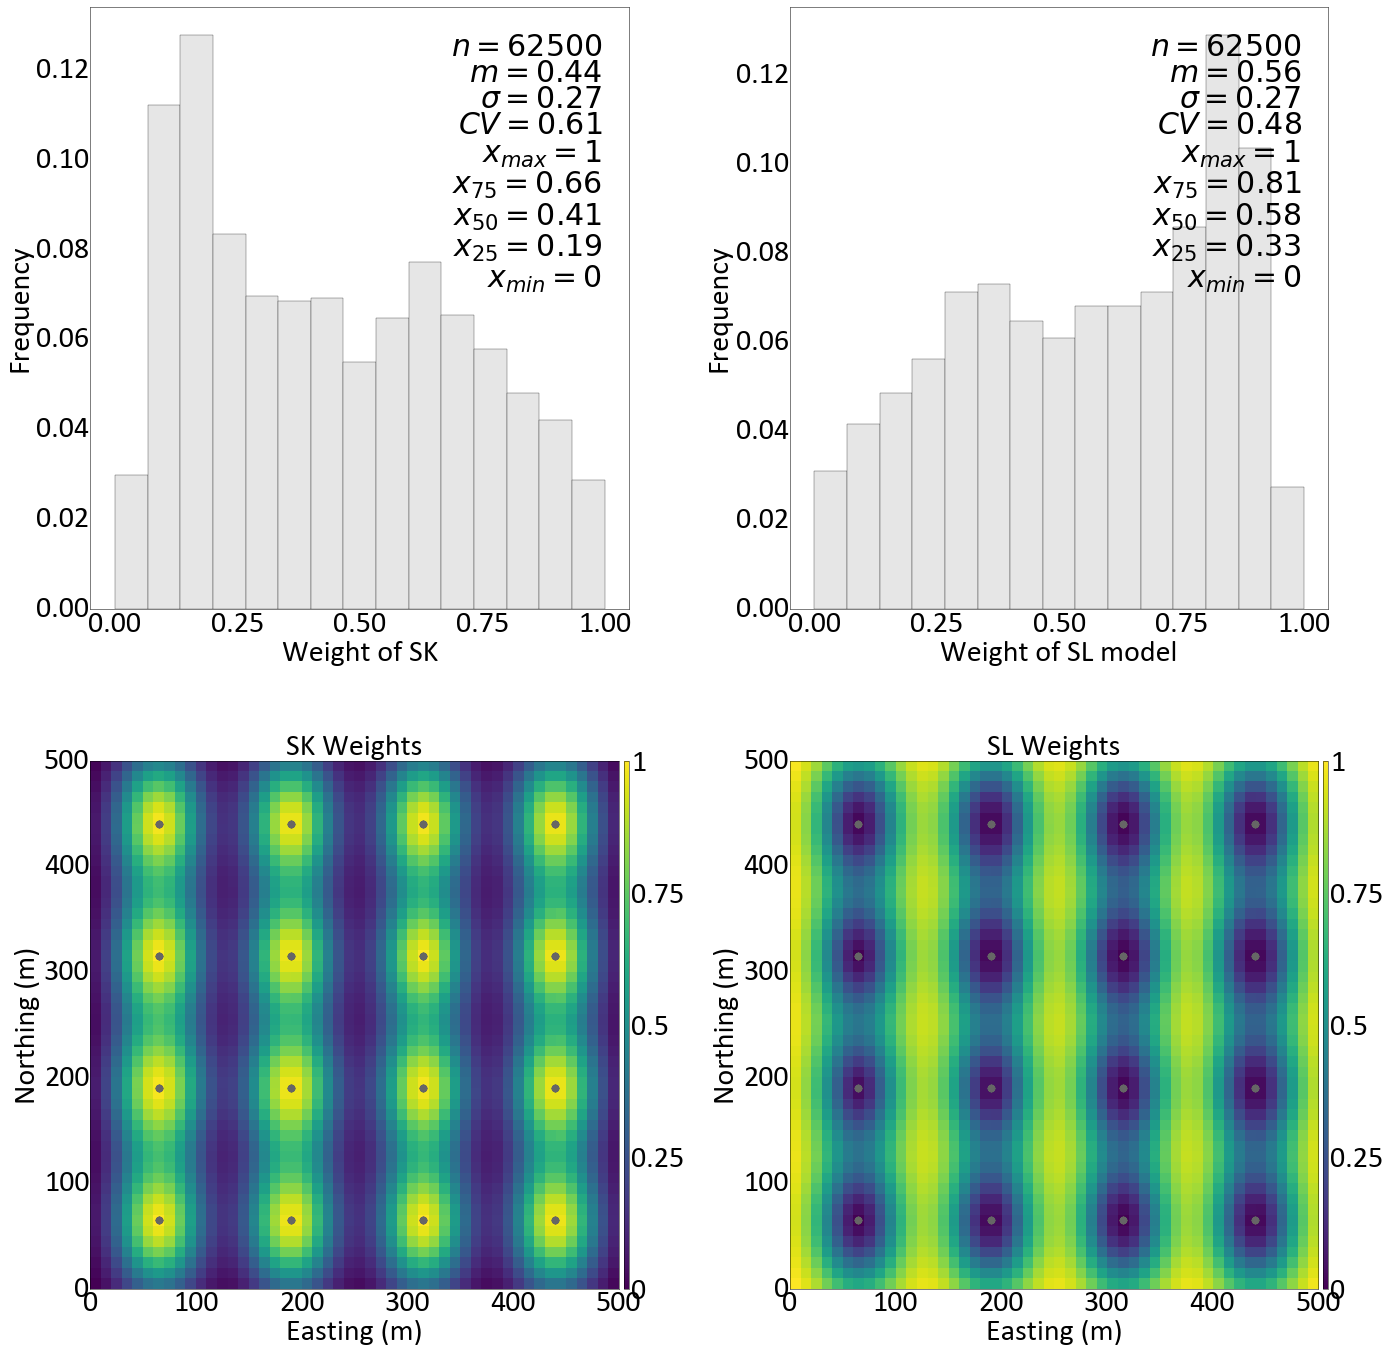

In [66]:
gs.set_style('pt30')
gridsize = (2,2)
lim2 = (0,1)

pltdat_WeightofSK = gs.DataFile('./predictions/WeightofSK.dat',griddef=griddef)
pltdat_WeightofML= gs.DataFile('./predictions/WeightofML.dat',griddef=griddef)


fig = plt.figure(figsize=(20,20))
ax1 = plt.subplot2grid(gridsize,(0,0)) 
ax2 = plt.subplot2grid(gridsize,(0,1))
ax3 = plt.subplot2grid(gridsize,(1,0)) 
ax4 = plt.subplot2grid(gridsize,(1,1))


gs.histplt(pltdat_WeightofSK ,ax=ax1, xlabel='Weight of SK')
gs.histplt(pltdat_WeightofML ,ax=ax2, xlabel='Weight of SL model')

gs.pixelplt(pltdat_WeightofSK,griddef=griddef,vlim = lim2, sliceno=15, ax=ax3,title = 'SK Weights')
gs.locmap(datasamplefl,griddef=griddef, ax=ax3,sliceno=10,x='X', y='Y', z='Z', title = 'SK Weights')

gs.pixelplt(pltdat_WeightofML,griddef=griddef, vlim = lim2, sliceno=15, ax=ax4,title = 'SL Weights')
gs.locmap(datasamplefl,griddef=griddef, ax=ax4,sliceno=10,x='X', y='Y', z='Z', title = 'SL Weights')

plt.savefig('./Figures/weight_hist_map.png',bbox_inches = 'tight', dpi = 150)
plt.tight_layout()

### plotting b0 and b1

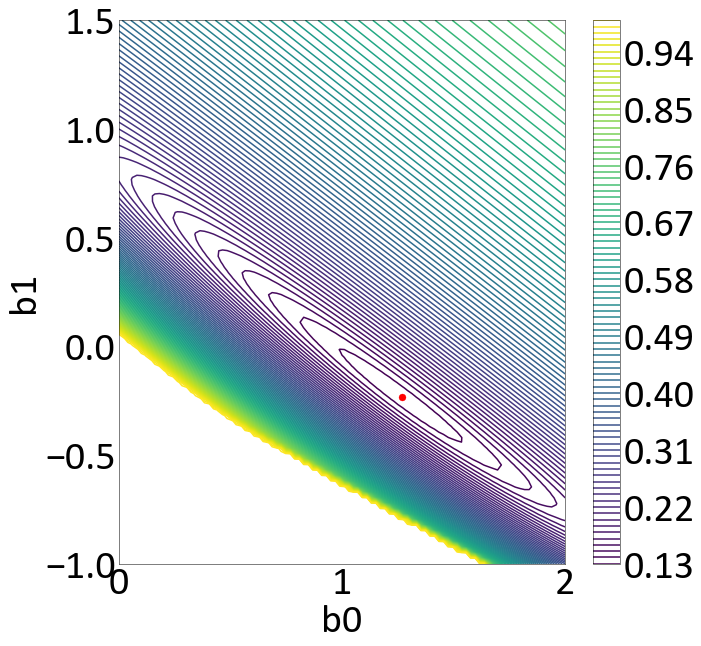

<Figure size 216x216 with 0 Axes>

In [67]:
gs.set_style('pt40')

# plot the function f(x)
x = np.linspace(0, 2, 100)
y = np.linspace(-1, 1.5, 100)

X, Y = np.meshgrid(x, y)
Z = np.zeros((x.size, y.size))
for i in range(x.size):
    for j in range(y.size):
        Z[i, j] = objective((x[i], y[j]))
        if Z[i, j] >= 1:
            Z[i, j] = 1
        else:
            Z[i, j] = Z[i, j] 

fig= plt.figure(figsize=(10,10))

plt.contour(X, Y, Z.T, 100);
plt.colorbar()
plt.scatter(res.x[0], res.x[1], c='red',alpha=1)
plt.xlabel('b0')
plt.ylabel('b1')
plt.show()

plt.savefig('./Figures/weightsopt.png',bbox_inches = 'tight', dpi = 150)
plt.tight_layout()

# COMPARISION

In [68]:
gs.write_gslib(pd.DataFrame(superlearner_opt),'./predictions/superlearner_opt.dat')
gs.write_gslib(pd.DataFrame(superlearner_comb),'./predictions/superlearner_comb.dat')
gs.write_gslib(pd.DataFrame(yhat_all),'./predictions/superlearner.dat')

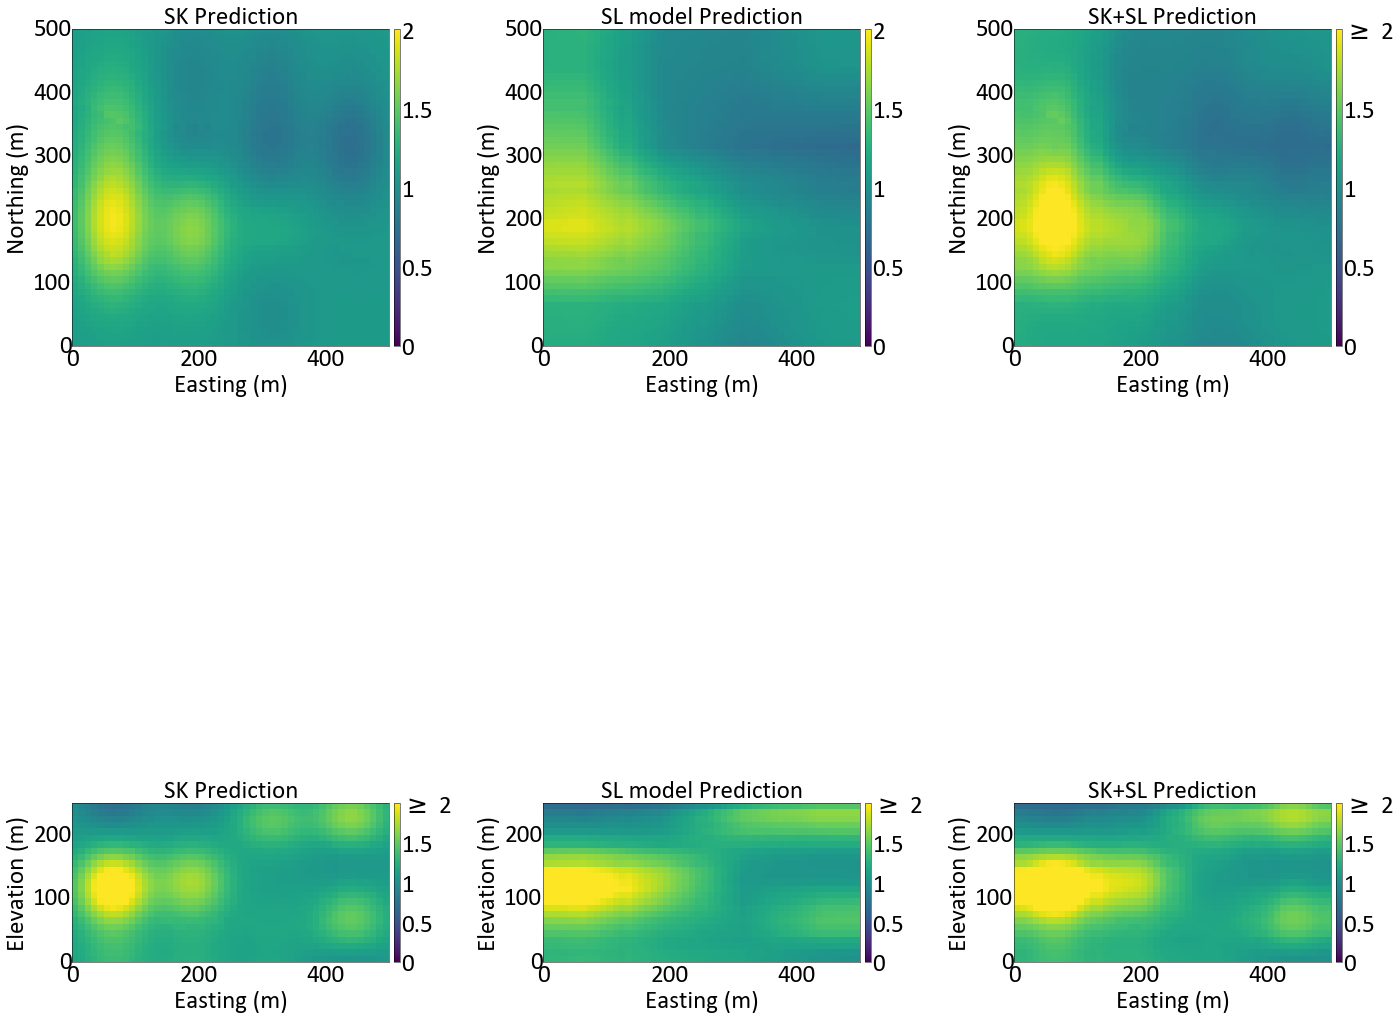

In [79]:
from scipy.ndimage import gaussian_filter

gs.set_style('pt25')

datafl = gs.DataFile('maketrend.out',griddef=griddef)
datasamplefl = gs.DataFile('dhs.out',griddef=griddef)
datasample = gs.DataFile(flname='./declus.out', x='X',y='Y',z='Z', griddef = griddef,
                           readfl=True)  
slinceno=15
vlim =(0,2)

var = 'value'
sigma = 0
gridsize = (1,4)


pltdat_kt3dn = gs.DataFile('./predictions/kt3dn.out',griddef=griddef)
pltdat_kt3dn.data['Estimate'][pltdat_kt3dn.data['Estimate'] < 0] = 0

pltdat_sl= gs.DataFile('./predictions/superlearner.dat',griddef=griddef)
pltdat_sl = (gaussian_filter((pltdat_sl.data['0']),sigma = sigma))
pltdat_sl[pltdat_sl < 0] = 0

pltdat_sl_comb= gs.DataFile('./predictions/superlearner_comb.dat',griddef=griddef)
pltdat_sl_comb = (gaussian_filter((pltdat_sl_comb.data['0']),sigma = sigma))
pltdat_sl_comb[pltdat_sl_comb < 0] = 0

pltdat_sl_opt = gs.DataFile('./predictions/superlearner_opt.dat',griddef=griddef)
pltdat_sl_opt = (gaussian_filter((pltdat_sl_opt.data['0']),sigma = sigma))
pltdat_sl_opt[pltdat_sl_opt < 0] = 0

gridsize2 = (2,3)

fig = plt.figure(figsize=(20,20))
ax1 = plt.subplot2grid(gridsize2,(0,0)) 
ax2 = plt.subplot2grid(gridsize2,(0,1))
ax3 = plt.subplot2grid(gridsize2,(0,2))
ax4 = plt.subplot2grid(gridsize2,(1,0)) 
ax5 = plt.subplot2grid(gridsize2,(1,1))
ax6 = plt.subplot2grid(gridsize2,(1,2))
# ax4 = plt.subplot2grid(gridsize2,(1,1))

    
gs.pixelplt(pltdat_kt3dn,griddef=griddef,vlim=vlim,sliceno=slinceno, ax=ax1,title = 'SK Prediction')
gs.pixelplt(pltdat_sl,griddef=griddef,vlim=vlim,sliceno=slinceno, ax=ax2,title = 'SL model Prediction')
# gs.pixelplt(pltdat_sl_comb,griddef=griddef,vlim=vlim,sliceno=slinceno, ax=ax3,title = 'SK+SL (without opt) Prediction')
gs.pixelplt(pltdat_sl_opt,griddef=griddef,vlim=vlim,sliceno=slinceno, ax=ax3,title = 'SK+SL Prediction')

gs.pixelplt(pltdat_kt3dn,orient = 'xz', griddef=griddef,vlim=vlim,sliceno=slinceno, ax=ax4,title = 'SK Prediction')
gs.pixelplt(pltdat_sl,orient = 'xz',griddef=griddef,vlim=vlim,sliceno=slinceno, ax=ax5,title = 'SL model Prediction')
# gs.pixelplt(pltdat_sl_comb,orient = 'xz',griddef=griddef,vlim=vlim,sliceno=slinceno, ax=ax3,title = 'SL+SK (without opt) Prediction')
gs.pixelplt(pltdat_sl_opt,orient = 'xz',griddef=griddef,vlim=vlim,sliceno=slinceno, ax=ax6,title = 'SK+SL Prediction')
plt.subplots_adjust (left = 0.1, bottom = 0.125, right = 1.6, top = 0.8, wspace = 0.2, hspace = 0.12)

plt.savefig('./Figures/Predictions.png',bbox_inches = 'tight', dpi = 150)
plt.tight_layout()


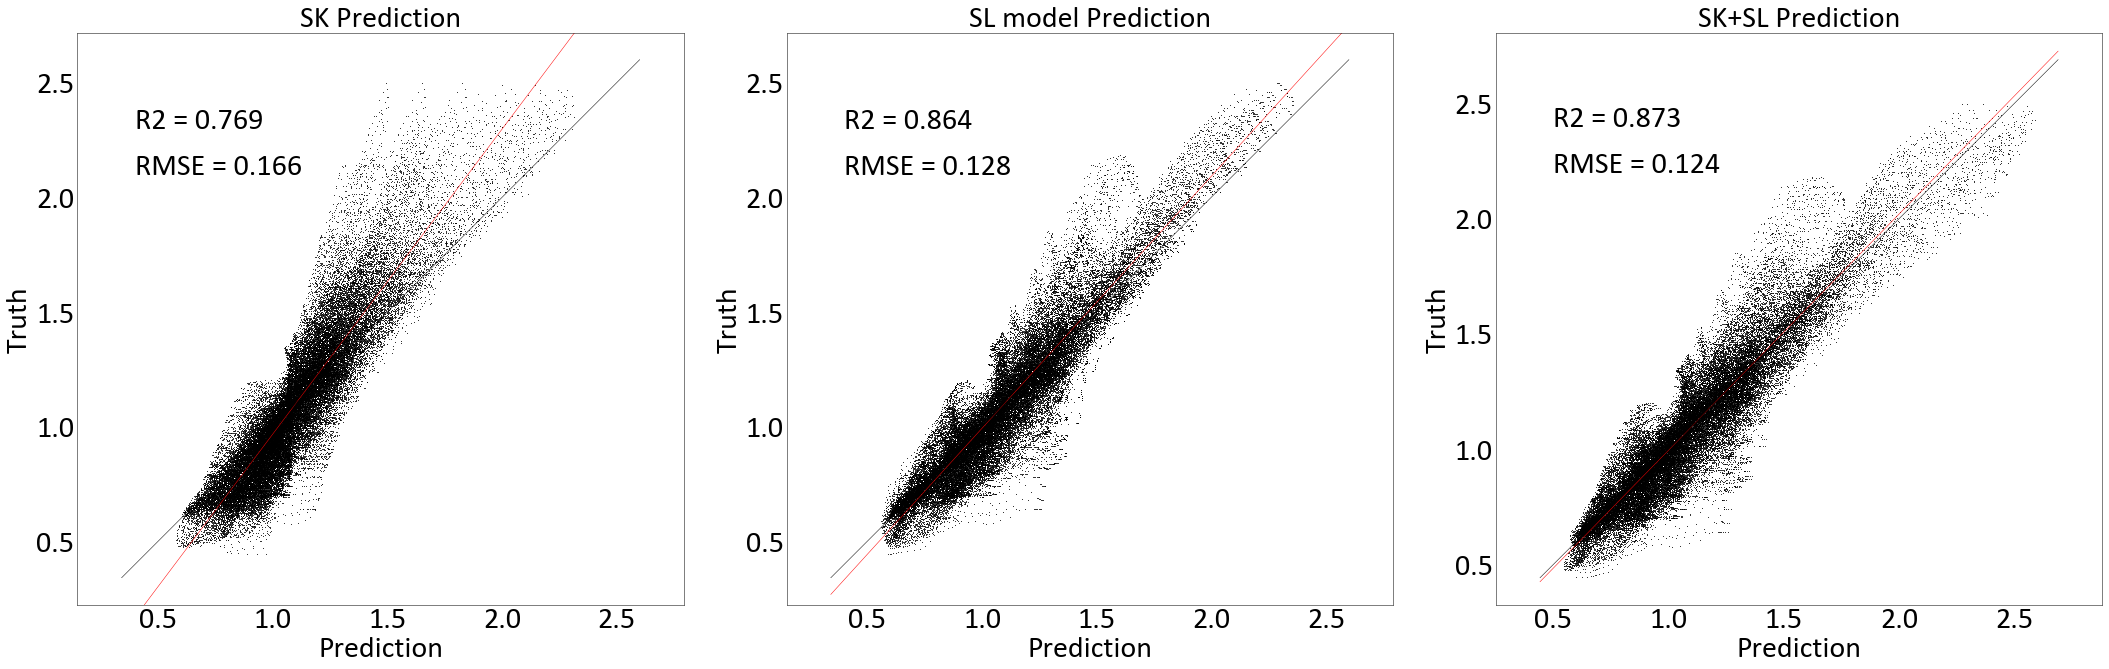

In [82]:
gs.set_style('pt30')
stat_blk = []

f, axes = plt.subplots(1, 3, figsize=(30, 10))

ax1 = gs.scatxval(pltdat_kt3dn.data['Estimate'],datafl.data['variable 1'], ax=axes[0],xlabel='Prediction',title = 'SK Prediction',
            ylabel ='Truth',ms =1 , stat_blk = stat_blk)

ax1.text(0.4,2.3,'R2 = {0:.3f}'.format(r2_score(datafl.data['variable 1'],pltdat_kt3dn.data['Estimate'])))
ax1.text(0.4,2.1,'RMSE = {0:.3f}'.format(sqrt(mean_squared_error(datafl.data['variable 1'],pltdat_kt3dn.data['Estimate']))))

ax2 = gs.scatxval(pltdat_sl,datafl.data['variable 1'], ax=axes[1],xlabel='Prediction',title = 'SL model Prediction',
            ylabel ='Truth',ms =1 , stat_blk = stat_blk)
ax2.text(0.4,2.3,'R2 = {0:.3f}'.format(r2_score(datafl.data['variable 1'],pltdat_sl)))
ax2.text(0.4,2.1,'RMSE = {0:.3f}'.format(sqrt(mean_squared_error(datafl.data['variable 1'],pltdat_sl))))


# gs.scatxval(pltdat_sl_comb,datafl.data['variable 1'], ax=ax3,xlabel='Prediction',title = 'SK+SL (without opt) Prediction',
#             ylabel ='Truth', ms =2)
# ax3.text(0.4,2.4,'R2 = {0:.3f}'.format(r2_score(datafl.data['variable 1'],pltdat_sl_comb)),size=25)
# ax3.text(0.4,2.2,'RMSE = {0:.3f}'.format(sqrt(mean_squared_error(datafl.data['variable 1'],pltdat_sl_comb)),size=25))

ax3 = gs.scatxval(pltdat_sl_opt,datafl.data['variable 1'], ax=axes[2],xlabel='Prediction',title = 'SK+SL Prediction',
            ylabel ='Truth',ms =1 , stat_blk = stat_blk)
ax3.text(0.5,2.4,'R2 = {0:.3f}'.format(r2_score(datafl.data['variable 1'],pltdat_sl_opt)))
ax3.text(0.5,2.2,'RMSE = {0:.3f}'.format(sqrt(mean_squared_error(datafl.data['variable 1'],pltdat_sl_opt))))

plt.savefig('./Figures/Data-Reproduction.png',bbox_inches = 'tight', dpi = 150)

plt.tight_layout()



In [72]:
def msre(predicted, actual):
	sum_error = 0.0
	for i in range(len(actual)):
		prediction_error = predicted[i] - actual[i]
		sum_error += (prediction_error ** 2)
	mean_error = sum_error / float(len(actual))
	return mean_error/ numpy.std(actual)

MSRE_SK = msre(np.asarray(pltdat_kt3dn.data['Estimate']),np.asarray(datafl.data['variable 1']))
MSRE_SL = msre(pltdat_sl,datafl.data['variable 1'])
MSRE_Combined= msre(pltdat_sl_comb,datafl.data['variable 1'])
MSRE_Optimizedcombined = msre(pltdat_sl_opt,datafl.data['variable 1'])

print('msre SK: %.3f' % MSRE_SK)
print('msre SL: %.3f' % MSRE_SL)
# print('msre SK+SL: %.3f' % MSRE_Combined)
print('msre SK+SL: %.3f' % MSRE_Optimizedcombined)

msre SK: 0.080
msre SL: 0.047
msre SK+SL: 0.044


In [73]:
from sklearn.metrics import make_scorer

# Calculate root mean squared error
def mean_error( predicted, actual):
	sum_error = 0.0
	for i in range(len(actual)):
		prediction_error = predicted[i] - actual[i]
		sum_error += (prediction_error)
	mean_error = sum_error / float(len(actual))
	return mean_error

meanerrorSK = mean_error(pltdat_kt3dn.data['Estimate'],datafl.data['variable 1'])
meanerrorSL = mean_error(pltdat_sl,datafl.data['variable 1'])
meanerrorCombined= mean_error(pltdat_sl_comb,datafl.data['variable 1'])
meanerrorOptimizedcombined = mean_error(pltdat_sl_opt,datafl.data['variable 1'])

print('mean error SK: %.3f' % round(meanerrorSK,1))
print('mean error SL: %.3f' % meanerrorSL)
# print('mean error SK+SL: %.3f' % meanerrorCombined)
print('mean error SK+SL: %.3f' % meanerrorOptimizedcombined)

mean error SK: -0.000
mean error SL: -0.003
mean error SK+SL: 0.001


### summary of statistics

In [74]:
#The Mean of Estimation

# print('Averaged model mean:%.3f' % (np.mean(average)))
# print('Non-optimized SK+SL mean:%.3f' % (np.mean(superlearner_comb)))
print('SK mean:%.3f' % (np.mean(SK)))
print('SL model mean:%.3f' % (np.mean(yhat_all)))
print('SK+SL mean:%.3f' % (np.mean(superlearner_opt)))
print('true mean:%.3f' % (np.mean(y_all)))

SK mean:1.107
SL model mean:1.106
SK+SL mean:1.111
true mean:1.109


In [75]:
#The Sigma of Estimation
# print('Non-optimized SK+SL SD:%.3f' % (np.std(superlearner_comb)))
# print('Averaged model SD:%.3f' % (np.std(average)))

print('SK SD: %.3f' % (np.std(SK)))
print('SL model SD:%.3f' % (np.std(yhat_all)))
print('SK+SL SD:%.3f' % (np.std(superlearner_opt)))
print('true SD:%.3f' % (np.std(y_all)))


SK SD: 0.236
SL model SD:0.294
SK+SL SD:0.316
true SD:0.346
